# Programming Exercise 4: Neural Networks Learning
## Machine Learning
## Introduction
In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

Files included in this exercise:
* `ex4.ipynb` - Python script that steps you through the exercise . 
* `ex4_utils.py` - All necessary functions, classes and solutions for the exercises.
* `ex4_data/ex4data1.mat` - Training set of hand-written digits.
* `ex4_data/ex4weights.mat` - Neural network parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ex4_utils import *
import scipy.io as io
import scipy.optimize as opt
from IPython.display import *
from sklearn.preprocessing import OneHotEncoder 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400   # 20x20 Input Images of Digits
hidden_layer_size = 25    # 25 hidden units
num_labels = 10#          #  10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)


## 1 Neural Networks
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to <i>learn</i> the parameters for the neural network.
The provided script will help you step through this exercise.
### 1.1 Visualizing the data
In the first part, the code will load the data and display it on a 2-dimensional plot (<b>Figure 1</b>) by calling the function <b>display_data</b>.

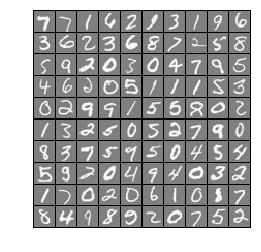

Figure 1: Random 100 examples from the dataset


In [3]:
#  =========== Part 1: Visualizing Data =============

# Load saved matrices from file
data = io.loadmat('ex4_data/ex4data1.mat')
X = data['X']
y = data['y']
m = X.shape[0]

# Randomly select 100 data points to display
randIndices = np.random.randint(0,m,100)
sel = X[randIndices,:]
img = display_data(sel)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
print('Figure 1: Random 100 examples from the dataset')

In [4]:
#One-hot encoding turns a class label n (out of k classes) 
#into a vector of length k where index n is "hot" (1) while
#the rest are zero. Scikit-learn has a built in utility we can use for this.    
encoder = OneHotEncoder(sparse=False)  
y_onehot = encoder.fit_transform(y) 
print("y_onehot's shape:", y_onehot.shape)

y_onehot's shape: (5000, 10)


This is the same dataset that you used in the previous exercise. There are 5000 training examples in <b>ex3data1.mat</b>, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$
X=\left[ \begin{array}{c}
    - (x^{(1)})^T -\\
    - (x^{(1)})^T - \\
    \vdots \\
    - (x^{(m)})^T - \\
\end{array} \right]
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with `numpy` indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

### 1.2 Model representation
Our neural network is shown in <b>Figure 2</b>. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20\times20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data will be loaded into the variables $X$ and $y$ by the script.

You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in <b>ex4weights.mat</b> and will be loaded into <i>Theta1</i> and <i>Theta2</i>. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).     

<b>Figure 2: Neural network model.</b>

<img src="nn.png" align="left" width="50%" height="50%">

In [5]:
#  ================ Part 2: Loading Pameters ================
#  In this part of the exercise, we load some pre-initialized 
#  neural network parameters.

weight = io.loadmat('ex4_data/ex4weights.mat')
# Load the weights into variables Theta1 and Theta2

Theta1 = weight['Theta1']
Theta2 = weight['Theta2']

# Unroll parameters 
nn_params = np.append(Theta1.flatten(order='K'), Theta2.flatten(order='K'), axis=0)
nn_params = nn_params.reshape((-1,1))
# nn_params = [Theta1(:) ; Theta2(:)];

print("Theta1's shape:", Theta1.shape)
print("Theta2's shape:", Theta2.shape)
print("nn_params' shape:", nn_params.shape)

Theta1's shape: (25, 401)
Theta2's shape: (10, 26)
nn_params' shape: (10285, 1)


### 1.3 Feedforward and cost function
Now you will implement the cost function and gradient for the neural network. First, complete the code in <b>nn_cost_function</b> to return the cost. Recall that the cost function for the neural network (without regularization) is

$$
\large{J(\theta) = \frac{1}{m}\sum^{m}_{i=1}\sum^{K}_{k=1}{[-y^{(i)}_k \log{((h_\theta(x^{(i)}))_k) - (1 - y^{(i)}_k) \log{(1 - (h_\theta(x^{(i)}))_k)}}]}} \text{   ,}
$$

where $h_\theta(x^{(i)})$ is computed as shown in the <b>Figure 2</b> and $K = 10$ is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a^{(3)}_k$ k is the activation (output value) of the $k$-th output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that

$$
\left. \begin{array}{ccccc}
y = \left[\begin{array}{c}
        1 \\ 0 \\ 0 \\ \vdots \\ 0
    \end{array} \right] 
     , &
    \left[\begin{array}{c}
        0 \\ 1 \\ 0 \\ \vdots \\ 0
    \end{array}\right]
    , &\ldots &\text{or}
    &\left [ \begin{array}{c}
        0 \\ 0 \\ 0 \\ \vdots \\ 1
    \end{array}\right] .
\end{array} \right.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.
You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \geq 3$ labels).

Once you are done, the script will call your <b>nn_cost_function</b> using the loaded set of parameters for <i>Theta1</i> and <i>Theta2</i>. You should see that the cost is about $0.287629$.

In [6]:
# ========== Part 3: Compute Cost (Feedforward) with no Regularization ==========
print('Feedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
lb = 0
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lb)

print('Cost at parameters (loaded from ex4weights): %0.6f' %J +
      '\n(this value should be about 0.287629)\n')

Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 0.287629
(this value should be about 0.287629)



### 1.4 Regularized cost function
The cost function for neural networks with regularization is given by
$$
\left. \huge{\begin{array}{rl} 
J(\theta) = &  \frac{1}{m} \sum^{m}_{i=1} \sum^{K}_{k=1}{[-y^{(i)}_k \log{((h_\theta(x^{(i)}))_k)}} - (1 - y^{(i)}_k) \log{(1 - (h_\theta(x^{(i)}))_k)}]  + \\
 & \frac{\lambda}{2m}  \sum^{25}_{j=1} \sum^{400}_{k=1}{[(\Theta^{(1)}_{j,k})^{2}} + \sum^{10}_{j=1} \sum^{25}_{k=1}{(\Theta^{(2)}_{j,k})^{2}}] \end{array}} \right.
$$

You can assume that the neural network will only have 3 layers – an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that <b>your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size</b>.

Note that you should not be regularizing the terms that correspond to the bias. For the matrices <i>Theta1</i> and <i>Theta2</i>, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing <b>nn_cost_function</b> and then later add the cost for the regularization terms.

Once you are done, the script will call your <b>nn_cost_function</b> using the loaded set of parameters for <i>Theta1</i> and <i>Theta2</i>, and $\lambda = 1$. You should see that the cost is about $0.383770$.

In [7]:
# =============== Part 4: Implement Regularization ===============
print('Checking Cost Function (w/ Regularization) ... ')

# Weight regularization parameter (we set this to 1 here).
lb = 1
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lb)

print('Cost at parameters (loaded from ex4weights): %0.6f' %J +
      '\n(this value should be about 0.383770)\n')

Checking Cost Function (w/ Regularization) ... 
Cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)



## 2 Backpropagation
In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the nn_cost_function so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\Theta)$ using an
advanced optimizer such as <b>fmin_tnc</b>. You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. Afteryou have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.
### 2.1 Sigmoid gradient
To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

$$ g'(z) = \frac{d}{dz}g(z) = g(z)(1 - g(z)) $$
$$\text{where} \qquad  \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} . $$

When you are done, try testing a few values by calling <b>sigmoid_gradient(z)</b>. For large values (both positive and negative) of $z$, the gradient should be close to $0$. When $z = 0$, the gradient should be exactly $0.25$. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [8]:
#  ================ Part 5: Sigmoid Gradient  ================
print('Evaluating sigmoid gradient...\n')
test = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoid_gradient(test)
np.set_printoptions(precision=3) #setup print options of nparray for more clear display
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: ', g)

Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:  [0.197 0.235 0.25  0.235 0.197]


#### 2.2 Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$.
You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient. 
Your job is to complete <b>rand_initialize_weights</b> to initialize the weights for $\Theta$

In [9]:
#  ================ Part 6: Initializing Pameters ================
#   In this part of the exercise, you will be starting to implment a two
#   layer neural network that classifies digits. You will start by
#   implementing a function to initialize the weights of the neural network

print('Initializing Neural Network Parameters ...\n')

initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.append(initial_Theta1.flatten(order='K'), initial_Theta2.flatten(order='K'), axis=0)
initial_nn_params = nn_params.reshape((-1,1))

Initializing Neural Network Parameters ...



#### 2.3 Backpropagation

<b>Figure 3: Backpropagation Updates.</b>
<img src="nn_updated.png" height="50%" width="50%">


Now, you will implement the backpropagation algorithm. Recall thatthe intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\Theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

In detail, here is the backpropagation algorithm (also depicted in <b>Figure 3</b>). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(1, m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the t th training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by m to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th}$ training example $x^{(t)}$. Perform a feedforward pass (<b>Figure 2</b>), computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add $a +1$ term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. 

2. For each output unit $k$ in layer 3 (the output layer), set
$$
\delta^{(3)}_k = (a^{(3)}_k - y_k),
$$

where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a different class $(y_k = 0). You may find logical arrays helpful for this task (explained in the previous programming exercise).

3. For the hidden layer $l = 2$, set
$$
    \delta^{(2)} = ({\Theta^{(2)})}^T \delta^{(3)}. *g'(z^{(2)})
$$

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$ 

$$
\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} {(a^{(l)})}^T
$$

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$ :
$$
\frac{\partial}{\partial\Theta^{(l)}_{ij}} J(\Theta) = D^{(l)}_{ij} = \frac{1}{m} \Delta^{(l)}_{ij}
$$
After you have implemented the backpropagation algorithm, the script will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.



#### 2.4 Gradient checking
In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine "unrolling" the parameters $\Theta^{(1)}, \Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of
the cost function being $J(θ)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(0)$ that purportedly computes $\frac{\partial}{\partial \theta j} J(\theta)$; you'd like to check if $f_i$ is outputting correct derivative values.

$$
\left. \begin{array}{rlcl}
\text{Let} & \theta^{(i+)} = \theta + \left[ \begin{array}{c} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{array}\right]
&  \text{and} & \theta^{(i-)} = \theta - \left[ \begin{array}{c} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{array}\right]
\end{array}\right.
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i$-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i$-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each $i$, that:

$$
f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}.
$$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{−4}$, you'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in <b>compute_numerical_gradient</b>. While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In the next step of the script, it will run the provided function <b>check_nn_gradients</b> which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct,you should see a relative difference that is less than $\text{1e-9}$.

<p style="border:3px; border-style:solid; border-color:#000000; padding: 1em;">
<b>Practical Tip: </b>When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number of parameters. Each dimension of θ requires two evaluations of the cost function and this can be expensive. In the function <b>check_nn_gradients</b>, our code creates a small random model and dataset which is used with <b>compute_numerical_gradient</b> for gradient checking. Furthermore, after you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.
</p>

<p style="border:3px; border-style:solid; border-color:#000000; padding: 1em;">
<b>Practical Tip: </b>Gradient checking works for any function where you are computing the cost and the gradient. Concretely, you can use the same <b>compute_numerical_gradient</b> function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression's cost function).
</p>

#### 2.5 Regularized Neural Networks
After you have successfully implemeted the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation.

Specifically, after you have computed $\Delta^{(l)}_{ij}$ using backpropagation, you should add regularization using

$$
\left. \large{\begin{array}{lr}
    \frac{\partial}{\partial \Theta^{(l)}_{ij}} J(\Theta) = D^{(l)}_{ij} = \frac{1}{m} ^{(l)}_{ij} & \text{for } j = 0 \\
    \frac{\partial}{\partial \Theta^{(l)}_{ij}} J(\Theta) = D^{(l)}_{ij} = \frac{1}{m} ^{(l)}_{ij} + \frac{\lambda}{m} \Theta^{(l)}_{ij} & \text{for } j \geq 1
\end{array}} \right.
$$

Note that you should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta^{(l)}_{ij}$ , $i$ is indexed starting from $1$, and $j$ is indexed starting from $0$. Thus,

$$
\large { \Theta^{(l)} = \left[ \begin{array}{ccc}
                            \Theta^{(i)}_{0,0} & \Theta^{(l)}_{0,1} & \ldots \\
                            \Theta^{(i)}_{1,0} & \Theta^{(l)}_{1,1} & \\
                            \vdots & & \ddots
                        \end{array} \right]} .
$$

Now modify your code that computes grad in <b>nn_cost_function</b> to account for regularization. After you are done, the script will proceed to run gradient checking on your implementation. <i>If your code is correct, you should expect to see a relative difference that is less than $\text{1e-9}$.</i>

In [10]:
check_nn_gradients() # without regularization -- lambda = 0

The below two columns you get should be very similar
Left-Your Numerical Gradient, Right-Analytical Gradient)
[[-9.278e-03 -9.278e-03]
 [ 8.899e-03  8.899e-03]
 [-8.360e-03 -8.360e-03]
 [ 7.628e-03  7.628e-03]
 [-6.748e-03 -6.748e-03]
 [-3.050e-06 -3.050e-06]
 [ 1.429e-05  1.429e-05]
 [-2.594e-05 -2.594e-05]
 [ 3.699e-05  3.699e-05]
 [-4.688e-05 -4.688e-05]
 [-1.751e-04 -1.751e-04]
 [ 2.331e-04  2.331e-04]
 [-2.875e-04 -2.875e-04]
 [ 3.353e-04  3.353e-04]
 [-3.762e-04 -3.762e-04]
 [-9.627e-05 -9.627e-05]
 [ 1.180e-04  1.180e-04]
 [-1.371e-04 -1.371e-04]
 [ 1.532e-04  1.532e-04]
 [-1.666e-04 -1.666e-04]
 [ 3.145e-01  3.145e-01]
 [ 1.111e-01  1.111e-01]
 [ 9.740e-02  9.740e-02]
 [ 1.641e-01  1.641e-01]
 [ 5.757e-02  5.757e-02]
 [ 5.046e-02  5.046e-02]
 [ 1.646e-01  1.646e-01]
 [ 5.779e-02  5.779e-02]
 [ 5.075e-02  5.075e-02]
 [ 1.583e-01  1.583e-01]
 [ 5.592e-02  5.592e-02]
 [ 4.916e-02  4.916e-02]
 [ 1.511e-01  1.511e-01]
 [ 5.370e-02  5.370e-02]
 [ 4.715e-02  4.715e-02]
 [ 1.496e-01  1

In [11]:
# =============== Part 8: Implement Regularization ===============
# Once your backpropagation implementation is correct, you should now
# continue to implement the regularization with the cost and gradient.

print('Checking Backpropagation (w/ Regularization) ... \n')

# Check gradients by running checkNNGradients
lambda_r = 3
check_nn_gradients(lambda_r)

#  Also output the costFunction debugging values
debug_J  = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r)[0]

print('Cost at (fixed) debugging parameters (w/ lambda = %f)' %lambda_r)
print('for lambda = 3, this value should be about 0.576051\n Cost:%f' %debug_J)

Checking Backpropagation (w/ Regularization) ... 

The below two columns you get should be very similar
Left-Your Numerical Gradient, Right-Analytical Gradient)
[[-9.278e-03 -9.278e-03]
 [ 8.899e-03  8.899e-03]
 [-8.360e-03 -8.360e-03]
 [ 7.628e-03  7.628e-03]
 [-6.748e-03 -6.748e-03]
 [-1.677e-02 -1.677e-02]
 [ 3.943e-02  3.943e-02]
 [ 5.934e-02  5.934e-02]
 [ 2.476e-02  2.476e-02]
 [-3.269e-02 -3.269e-02]
 [-6.017e-02 -6.017e-02]
 [-3.196e-02 -3.196e-02]
 [ 2.492e-02  2.492e-02]
 [ 5.977e-02  5.977e-02]
 [ 3.864e-02  3.864e-02]
 [-1.737e-02 -1.737e-02]
 [-5.757e-02 -5.757e-02]
 [-4.520e-02 -4.520e-02]
 [ 9.146e-03  9.146e-03]
 [ 5.461e-02  5.461e-02]
 [ 3.145e-01  3.145e-01]
 [ 1.111e-01  1.111e-01]
 [ 9.740e-02  9.740e-02]
 [ 1.187e-01  1.187e-01]
 [ 3.819e-05  3.819e-05]
 [ 3.369e-02  3.369e-02]
 [ 2.040e-01  2.040e-01]
 [ 1.171e-01  1.171e-01]
 [ 7.548e-02  7.548e-02]
 [ 1.257e-01  1.257e-01]
 [-4.076e-03 -4.076e-03]
 [ 1.697e-02  1.697e-02]
 [ 1.763e-01  1.763e-01]
 [ 1.131e-01  

#### 2.6 Learning parameters using `fmin_tnc`
After you have successfully implemented the neural network cost function and gradient computation, the next step of the script will use <b>fmin_tnc</b> to learn a good set parameters.

After the training completes, the ex4.m script will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about $95.3\%$ (this may vary by about $1\%$ due to the random initialization). It is possible to get higher training accuracies by
training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set `MaxIter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [12]:
#  =================== Part 8: Training NN ===================
print('Training Neural Network... \n')

#  You should also try different values of lambda
lb = 1

# Set up for printing out iterations
count = 1
def callbackF(Xi):
    global count
    print('Iter: {}   Cost: {:04f}'.format(count, func(Xi)))
    count += 1

func = lambda j: compute_cost(j, input_layer_size, hidden_layer_size, num_labels, X, y, lb)
pr = lambda gr: compute_gradient(gr, input_layer_size, hidden_layer_size, num_labels, X, y, lb)
    
result = opt.fmin_tnc(func=func, x0=initial_nn_params,
                      fprime=pr,disp=True, maxCGit=4, maxfun=100, callback=callbackF)

nn_params = result[0]

Theta1 = nn_params[:hidden_layer_size*(input_layer_size+1)]
Theta1 = np.reshape(Theta1, (hidden_layer_size, input_layer_size+1), order='F')

Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):]
Theta2 = np.reshape(Theta2, (num_labels, hidden_layer_size+1), order='F')

Training Neural Network... 

Iter: 1   Cost: 0.358233
Iter: 2   Cost: 0.347929
Iter: 3   Cost: 0.341154
Iter: 4   Cost: 0.336459
Iter: 5   Cost: 0.332056
Iter: 6   Cost: 0.328732
Iter: 7   Cost: 0.326378
Iter: 8   Cost: 0.324248
Iter: 9   Cost: 0.322672
Iter: 10   Cost: 0.321443
Iter: 11   Cost: 0.320453
Iter: 12   Cost: 0.319667
Iter: 13   Cost: 0.318956
Iter: 14   Cost: 0.317605
Iter: 15   Cost: 0.316953
Iter: 16   Cost: 0.316477
Iter: 17   Cost: 0.316122
Iter: 18   Cost: 0.315759
Iter: 19   Cost: 0.315471
Iter: 20   Cost: 0.315187


### 3 Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value $(a^{(l)})$ close to $1$). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vectorthat represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the "representation" captured by the hidden unit is to reshape this 400 dimensional vector into a $20 \times 20$ image and display it. The next step does this by using the <b>display_data</b> function and it will show you an image (similar to Figure 4) with $25$ units, each corresponding to one hidden unit in the network.

In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

<b>Figure 4: Visualization of Hidden Units. </b>

<img src="hidden_units.png" align="left" height="30%" width="30%">


Visualizing Neural Network... 



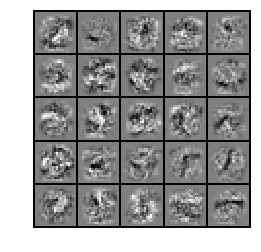

In [43]:
#  ================= Part 9: Visualize Weights =================

print('Visualizing Neural Network... \n')
img = display_data(Theta1[:,1:])
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [42]:
#  ================= Part 10: Implement Predict =================
#  After training the neural network, we would like to use it to predict the labels of the training set. 

p = predict(Theta1, Theta2, X)
eq = np.equal(p.reshape((-1,1)),y)
acc = (np.sum(eq)/5000)*100
print('Training Set Accuracy: %0.2f' %acc)

Training Set Accuracy: 99.34
